<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/deep_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://web.stanford.edu/group/deepsolar/home.html

TODO: 

1. Improve current model arch
2. Predict a DeepSolar value and remove others.
3. Predict multiple DeepSolar outputs



In [4]:
import tensorflow as tf
import random

seed=53
tf.random.set_seed(seed)
random.seed(seed)

tf.__version__

'2.8.2'

# Get the data

In [5]:
!curl http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv -o deepsolar_tract.csv
!curl http://web.stanford.edu/group/deepsolar/deepsolar_tract_meta.csv -o deepsolar_tract_meta.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  107M  100  107M    0     0   811k      0  0:02:15  0:02:15 --:--:--  889k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15301  100 15301    0     0  32555      0 --:--:-- --:--:-- --:--:-- 32555


In [6]:
import pandas as pd
data = pd.read_csv('deepsolar_tract.csv', encoding='latin-1', index_col=0)
metadata = pd.read_csv('deepsolar_tract_meta.csv')
data.shape

(72537, 168)

In [7]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72537 entries, 0 to 72537
Data columns (total 168 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    tile_count                               72537 non-null  float64
 1    solar_system_count                       72537 non-null  float64
 2    total_panel_area                         72537 non-null  float64
 3    fips                                     72537 non-null  int64  
 4    average_household_income                 71651 non-null  float64
 5    county                                   72537 non-null  object 
 6    education_bachelor                       72537 non-null  int64  
 7    education_college                        72537 non-null  int64  
 8    education_doctoral                       72537 non-null  int64  
 9    education_high_school_graduate           72537 non-null  int64  
 10   education_less_than_high_school 

In [8]:
def get_column_explanation(column_name):
  explanation = metadata[metadata['column_name'] == column_name]['explanation'].values
  return explanation[0]

In [9]:
get_column_explanation('land_area')

'total land area (mile^2)'

In [10]:
get_column_explanation('total_area')

'total area (mile^2)'

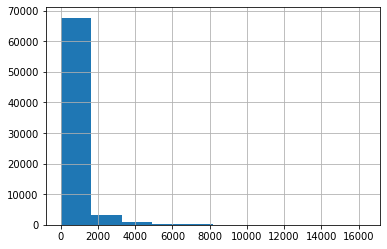

In [11]:
# Predict solar_panel_area_divided_by_area
data.rename(columns={'solar_panel_area_divided_by_area':'target'}, inplace=True)
data = data[data['target'].notna()]
data.target.hist()

In [12]:
# some outliers
# num_outliers = 0
# for index, row in data.iterrows():
#   if row.target > 10000 :
#     print(str(index) + ' : ' + str(row.target))
#     num_outliers += 1
# print(num_outliers)

In [13]:
get_column_explanation('fips')

'census tract FIPS number'

In [14]:
assert data.fips.nunique() == data.shape[0]
data.drop('fips', axis='columns', inplace=True)

In [15]:
# data.electricity_price_transportation.value_counts(dropna=False)

In [16]:
import numpy as np
# data['electricity_price_transportation'] = data.electricity_price_transportation.replace(' ', np.nan).astype(float)
# apparently very little data available
data.drop('electricity_price_transportation', axis='columns', inplace=True)
data.drop('voting_2012_dem_percentage', axis='columns', inplace=True)
data.drop('voting_2012_gop_percentage', axis='columns', inplace=True)

In [17]:
# dropping columns which leak target information
data.drop(['tile_count_residential', 'solar_system_count_residential', 'total_panel_area_residential',
           'solar_system_count', 'tile_count', 'solar_panel_area_per_capita', 'number_of_solar_system_per_household',
           'total_panel_area', 'tile_count_nonresidential', 'solar_system_count_nonresidential',
           'total_panel_area_nonresidential'], axis='columns', inplace=True)

In [18]:
data['voting_2012_dem_win'] = data.voting_2012_dem_win.astype(int)
data['voting_2016_dem_win'] = data.voting_2016_dem_win.astype(int)

In [19]:
def impute_with_county_mean(column_name):
  missing = data.loc[data[column_name].isna()]

  for idx,row in missing.iterrows():
    temp = data.loc[(data['county'] == row.county) & (data['state'] == row.state) & 
                          (data[column_name].notna())]
    value = temp[column_name].mean()
    data.loc[idx, column_name] = value

def impute_with_state_mean(column_name):
  missing = data.loc[data[column_name].isna()]

  for idx,row in missing.iterrows():
    temp = data.loc[(data['county'] == row.county) & 
                          (data[column_name].notna())]
    value = temp[column_name].mean()
    data.loc[idx, column_name] = value

In [20]:
%%time
counts = data.isna().sum()
counts = counts[counts > 0]
for column_name in counts.index:
  print(column_name)
  impute_with_county_mean(column_name)


average_household_income
gini_index
per_capita_income
population_density
education_less_than_high_school_rate
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
education_professional_school_rate
education_doctoral_rate
race_white_rate
race_black_africa_rate
race_indian_alaska_rate
race_asian_rate
race_islander_rate
race_other_rate
race_two_more_rate
employ_rate
poverty_family_below_poverty_level_rate
heating_fuel_gas_rate
heating_fuel_electricity_rate
heating_fuel_fuel_oil_kerosene_rate
heating_fuel_coal_coke_rate
heating_fuel_solar_rate
heating_fuel_other_rate
heating_fuel_none_rate
median_household_income
average_household_size
housing_unit_median_value
housing_unit_median_gross_rent
lat
lon
elevation
heating_design_temperature
cooling_design_temperature
earth_temperature_amplitude
frost_days
air_temperature
relative_humidity
daily_solar_radiation
atmospheric_pressure
wind_speed
earth_temperature
heating_degree_days
cooling_degre

In [21]:
counts = data.isna().sum()
counts[counts > 0]

median_household_income            1
housing_unit_median_value          2
housing_unit_median_gross_rent     1
lat                               11
lon                               11
elevation                         11
heating_design_temperature        11
cooling_design_temperature        11
earth_temperature_amplitude       11
frost_days                        11
air_temperature                   11
relative_humidity                 11
daily_solar_radiation             11
atmospheric_pressure              11
wind_speed                        11
earth_temperature                 11
heating_degree_days               11
cooling_degree_days               11
dropout_16_19_inschool_rate        1
dtype: int64

In [22]:
counts = data.isna().sum()
counts = counts[counts > 0]
for column_name in counts.index:
  print(column_name)
  impute_with_state_mean(column_name)

median_household_income
housing_unit_median_value
housing_unit_median_gross_rent
lat
lon
elevation
heating_design_temperature
cooling_design_temperature
earth_temperature_amplitude
frost_days
air_temperature
relative_humidity
daily_solar_radiation
atmospheric_pressure
wind_speed
earth_temperature
heating_degree_days
cooling_degree_days
dropout_16_19_inschool_rate


In [23]:
counts = data.isna().sum()
counts[counts > 0]

median_household_income           1
housing_unit_median_value         2
housing_unit_median_gross_rent    1
lat                               4
lon                               4
elevation                         4
heating_design_temperature        4
cooling_design_temperature        4
earth_temperature_amplitude       4
frost_days                        4
air_temperature                   4
relative_humidity                 4
daily_solar_radiation             4
atmospheric_pressure              4
wind_speed                        4
earth_temperature                 4
heating_degree_days               4
cooling_degree_days               4
dropout_16_19_inschool_rate       1
dtype: int64

In [24]:
# drop the other rows with missing
data.dropna(inplace=True)

In [25]:
data = pd.get_dummies(data, columns=['state'])

In [26]:
cols = data.columns
cols = cols.drop('county')
# cols = cols.drop('electricity_price_transportation')

correlations = pd.Series(dtype=float)
for c in cols:
  # print(c)
  # print(data.target.corr(data[c]))
  correlations[c] = data.target.corr(data[c])

correlations = correlations.sort_values(ascending=False)
correlations = correlations.drop('target')
print(correlations.head(10))
print('')
print(correlations.tail(10))

state_ca                             0.554795
incentive_count_nonresidential       0.509081
incentive_count_residential          0.498916
feedin_tariff                        0.474948
electricity_price_industrial         0.425127
rebate                               0.422419
daily_solar_radiation                0.421982
electricity_price_commercial         0.408567
electricity_price_overall            0.378943
incentive_residential_state_level    0.366352
dtype: float64

lat                                   -0.150722
travel_time_less_than_10_rate         -0.157015
occupancy_vacant_rate                 -0.162703
education_high_school_graduate_rate   -0.219415
voting_2016_gop_percentage            -0.247091
heating_degree_days                   -0.259020
electricity_consume_residential       -0.302190
frost_days                            -0.315227
lon                                   -0.398568
relative_humidity                     -0.468520
dtype: float64


In [27]:
get_column_explanation('heating_degree_days')

'heating degree days'

In [28]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72505 entries, 0 to 72537
Data columns (total 201 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    average_household_income                 72505 non-null  float64
 1    county                                   72505 non-null  object 
 2    education_bachelor                       72505 non-null  int64  
 3    education_college                        72505 non-null  int64  
 4    education_doctoral                       72505 non-null  int64  
 5    education_high_school_graduate           72505 non-null  int64  
 6    education_less_than_high_school          72505 non-null  int64  
 7    education_master                         72505 non-null  int64  
 8    education_population                     72505 non-null  int64  
 9    education_professional_school            72505 non-null  int64  
 10   employed                        

In [29]:
# TODO: how do fips relate to county, any other way to use county?
data.county.nunique()
data.drop('county', axis='columns', inplace=True)

In [30]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=seed)
test, val = train_test_split(test, test_size=0.5, random_state=seed)
train.shape, val.shape, test.shape

((58004, 200), (7251, 200), (7250, 200))

In [31]:
x_train = train.drop('target', axis='columns')
y_train = train.target.values
x_val = val.drop('target', axis='columns')
y_val = val.target.values
x_test = test.drop('target', axis='columns')
y_test = test.target.values

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [33]:
tf.keras.backend.clear_session()

inp = tf.keras.Input(shape=(x_train.shape[1],))
x = tf.keras.layers.Dense(512, activation='swish')(inp)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)

# x = tf.keras.layers.Dense(512, activation='swish')(x)
# x = tf.keras.layers.Dense(512, activation='swish')(x)
# x = tf.keras.layers.Dense(512, activation='swish')(x)
# x = tf.keras.layers.Dense(512, activation='swish')(x)
# x = tf.keras.layers.Dense(512, activation='swish')(x)
# x = tf.keras.layers.Dense(512, activation='swish')(x)

out = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 199)]             0         
                                                                 
 dense (Dense)               (None, 512)               102400    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0     

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='mse',
              metrics=['mae'])
es = tf.keras.callbacks.EarlyStopping(patience=19, verbose=1, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=500, batch_size=128, validation_data=(x_val, y_val),
                    callbacks=[es], verbose=2)

Epoch 1/500
454/454 - 26s - loss: 788097.9375 - mae: 333.9293 - val_loss: 480943.1250 - val_mae: 304.6456 - 26s/epoch - 56ms/step
Epoch 2/500
454/454 - 24s - loss: 483708.4375 - mae: 286.2112 - val_loss: 430505.0000 - val_mae: 275.8751 - 24s/epoch - 53ms/step
Epoch 3/500
454/454 - 23s - loss: 443679.1875 - mae: 268.4156 - val_loss: 410210.9375 - val_mae: 270.9860 - 23s/epoch - 52ms/step
Epoch 4/500
454/454 - 24s - loss: 420181.9062 - mae: 259.3745 - val_loss: 388129.0312 - val_mae: 260.5923 - 24s/epoch - 53ms/step
Epoch 5/500
454/454 - 24s - loss: 401498.7188 - mae: 253.0894 - val_loss: 374127.1875 - val_mae: 255.2944 - 24s/epoch - 53ms/step
Epoch 6/500
454/454 - 24s - loss: 385065.5312 - mae: 246.1200 - val_loss: 360368.1250 - val_mae: 250.8113 - 24s/epoch - 53ms/step
Epoch 7/500
454/454 - 24s - loss: 375575.0312 - mae: 244.0879 - val_loss: 348959.5312 - val_mae: 245.9729 - 24s/epoch - 53ms/step
Epoch 8/500
454/454 - 24s - loss: 364328.6562 - mae: 240.6567 - val_loss: 350450.0938 - va

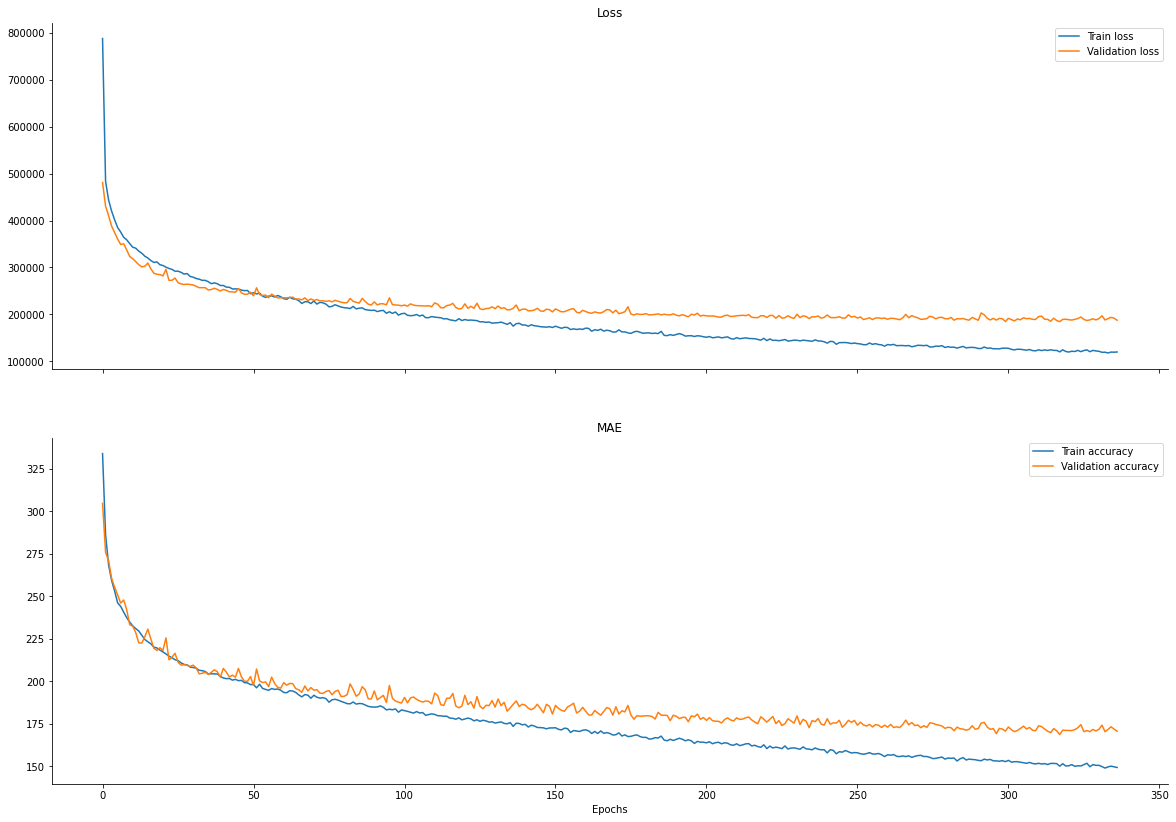

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Train accuracy')
ax2.plot(history['val_mae'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [36]:
model.evaluate(x_test, y_test)

227/227 [==============================] - 2s 8ms/step - loss: 197075.3125 - mae: 171.4315


[197075.3125, 171.4314727783203]

* baseline xgboost (10000 rounds)  : loss: 161178.1402 - mae: 192.6809
* baseline, StandardScaler         : loss: 207838.6875 - mae: 177.4304
* MinMaxScaler                     : loss: 188362.1406 - mae: 179.4975
* RobustScaler                     : loss: 211240.9375 - mae: 182.4861
* deeper network                   : loss: 212427.9375 - mae: 200.2194
* lr=1e-4                          : loss: 214194.5156 - mae: 176.9419
* lr=1e-5                          : loss: 231378.9062 - mae: 186.8908
* dropout(0.1)                     : **loss: 197075.3125 - mae: 171.4315**
* thinner model                    : 
* batchnorm ?


## XGBoost baseline

In [37]:
import xgboost as xgb
xgb.__version__

'0.90'

In [38]:
model = xgb.XGBRegressor(random_state=seed, objective='reg:squarederror', n_estimators=100)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)])

[0]	validation_0-rmse:938.108	validation_1-rmse:903.62
[1]	validation_0-rmse:891.014	validation_1-rmse:856.928
[2]	validation_0-rmse:850.739	validation_1-rmse:817.444
[3]	validation_0-rmse:815.907	validation_1-rmse:783.561
[4]	validation_0-rmse:786.571	validation_1-rmse:755.042
[5]	validation_0-rmse:761.207	validation_1-rmse:731.676
[6]	validation_0-rmse:739.202	validation_1-rmse:710.016
[7]	validation_0-rmse:720.61	validation_1-rmse:692.997
[8]	validation_0-rmse:703.945	validation_1-rmse:676.859
[9]	validation_0-rmse:689.64	validation_1-rmse:663.965
[10]	validation_0-rmse:674.427	validation_1-rmse:648.705
[11]	validation_0-rmse:663.102	validation_1-rmse:638.726
[12]	validation_0-rmse:652.489	validation_1-rmse:628.243
[13]	validation_0-rmse:642.451	validation_1-rmse:617.972
[14]	validation_0-rmse:634.228	validation_1-rmse:610.613
[15]	validation_0-rmse:626.408	validation_1-rmse:602.699
[16]	validation_0-rmse:618.85	validation_1-rmse:595.175
[17]	validation_0-rmse:612.955	validation_1-r

XGBRegressor(objective='reg:squarederror', random_state=53)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

227004.07504237202
218.67484877978413
